In [36]:
import os

import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt

eda_middle_data_path = 'eda-middle-data/'

res = pd.DataFrame([], columns=['pcode', 'max_amplitude', 'scr_count_per_minute'])
measurement = 'max_amplitude'

for p_index in range(80):
    participant_key = 'P' + str(p_index + 1).zfill(2)
    file_path = eda_middle_data_path + participant_key + '_eda_result.csv'

    if not os.path.isfile(file_path):
        print(file_path + ' do not exist!')
        continue

    df = pd.read_csv(file_path)
    
    if len(df) < 5:
        print(file_path + ' has too less data!')
        continue
        
    res.loc[len(res)] = [participant_key, df['max_amplitude'].mean(), df['scr_count_per_minute'].mean()]

res

eda-middle-data/P01_eda_result.csv has too less data!
eda-middle-data/P02_eda_result.csv has too less data!
eda-middle-data/P03_eda_result.csv has too less data!
eda-middle-data/P04_eda_result.csv has too less data!
eda-middle-data/P05_eda_result.csv has too less data!
eda-middle-data/P06_eda_result.csv has too less data!
eda-middle-data/P07_eda_result.csv has too less data!
eda-middle-data/P08_eda_result.csv has too less data!
eda-middle-data/P10_eda_result.csv has too less data!
eda-middle-data/P11_eda_result.csv has too less data!
eda-middle-data/P12_eda_result.csv has too less data!
eda-middle-data/P13_eda_result.csv has too less data!
eda-middle-data/P14_eda_result.csv has too less data!
eda-middle-data/P20_eda_result.csv has too less data!
eda-middle-data/P25_eda_result.csv has too less data!
eda-middle-data/P27_eda_result.csv do not exist!
eda-middle-data/P28_eda_result.csv has too less data!
eda-middle-data/P29_eda_result.csv has too less data!
eda-middle-data/P30_eda_result.cs

,pcode,max_amplitude,scr_count_per_minute
0,P09,0.038409,11.310318
1,P15,0.455430,6.893389
2,P16,0.854906,6.019064
3,P17,0.198644,3.363442
4,P18,0.399582,26.036770
5,P19,0.023650,9.034546
6,P21,0.463911,4.841211
7,P22,0.068654,12.589667
8,P23,0.195657,9.986961
9,P24,0.553094,9.072991


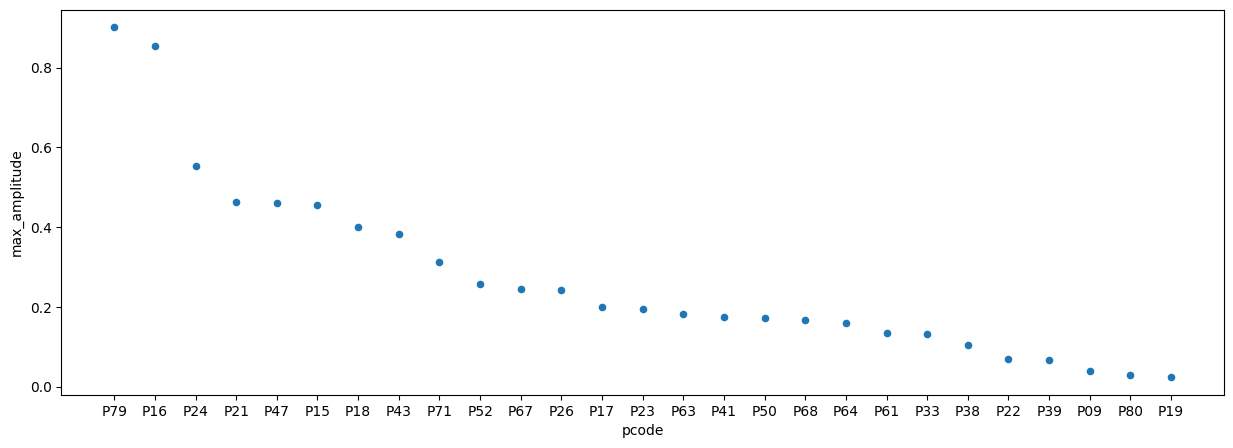

In [37]:
res.sort_values(by=measurement, ascending=False, inplace=True)
plot = res.plot(x='pcode', y=measurement, kind='scatter', figsize=(15, 5))

In [38]:
df_subj = pd.read_csv('dataset/SubjData/UserInfo.csv')
df_subj

,pcode,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,P01,2019-05-08,27,M,11,11,3,4,13,13,0,1
1,P02,2019-05-08,21,M,14,5,12,14,5,27,6,18
2,P03,2019-05-08,24,F,10,15,8,7,11,18,2,6
3,P04,2019-05-08,23,M,12,11,8,6,11,20,1,9
4,P05,2019-05-08,27,F,10,11,13,10,6,25,14,9
...,...,...,...,...,...,...,...,...,...,...,...,...
72,P76,2019-04-30,18,M,8,8,12,6,8,21,14,21
73,P77,2019-04-30,18,M,11,12,7,11,10,7,2,7
74,P78,2019-04-30,17,M,12,11,9,12,10,10,2,7
75,P79,2019-04-30,23,M,9,10,7,12,11,13,2,6


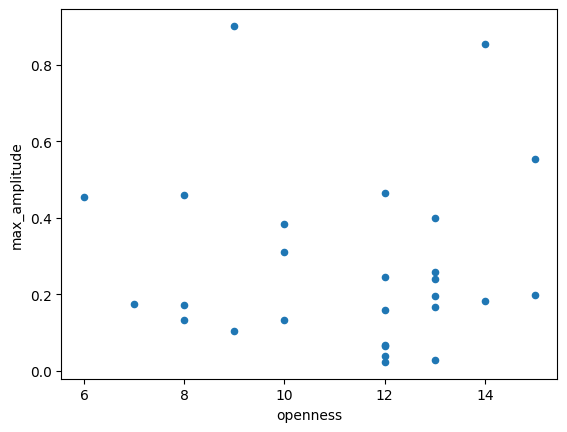

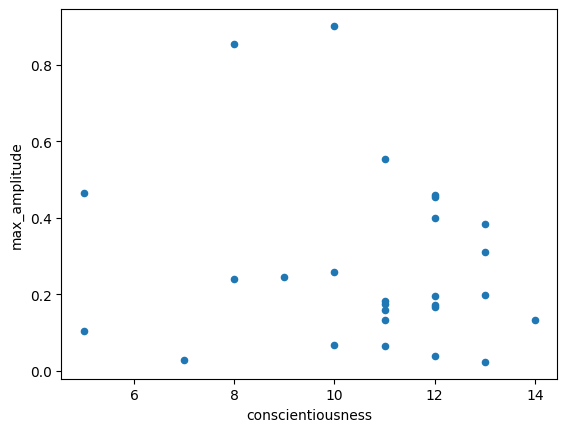

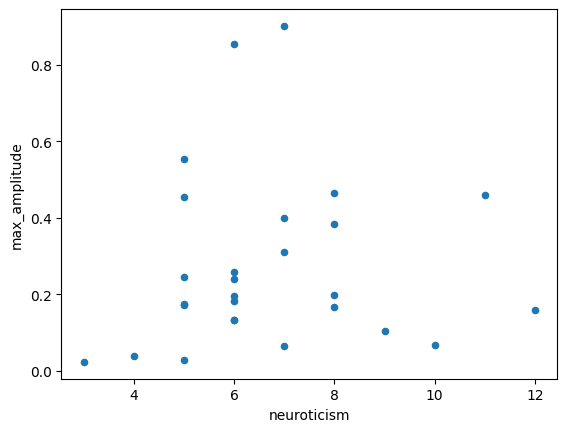

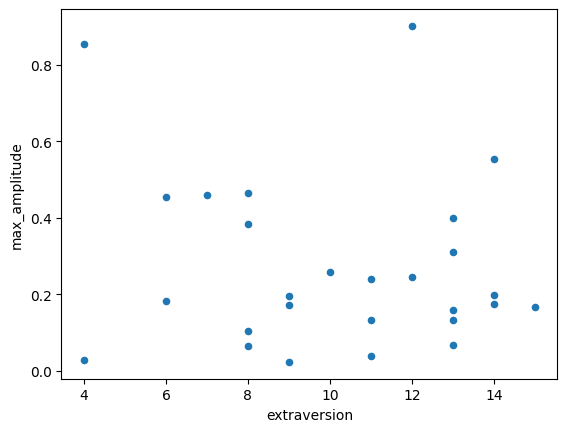

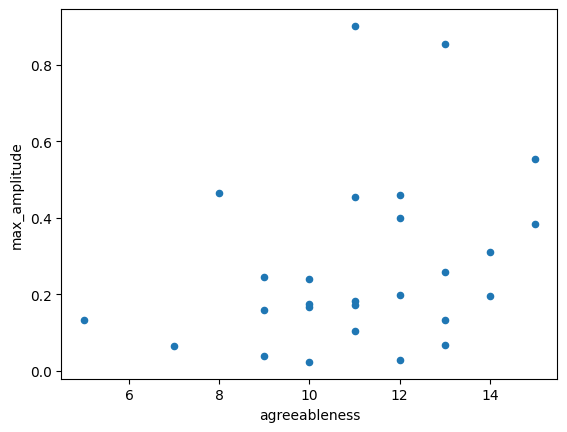

In [39]:
personality_traits = ['openness', 'conscientiousness', 'neuroticism', 'extraversion', 'agreeableness']
df_test = pd.merge(res, df_subj, on='pcode')

for trait in personality_traits:
    df_test.plot(x=trait, y=measurement, kind='scatter')


In [40]:
import statsmodels.api as sm

X = df_test[personality_traits]
y = df_test[measurement]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:          max_amplitude   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                 -0.066
Method:                 Least Squares   F-statistic:                    0.6774
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.645
Time:                        02:47:24   Log-Likelihood:                 4.2443
No. Observations:                  27   AIC:                             3.511
Df Residuals:                      21   BIC:                             11.29
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2224      0.40

ShapiroResult(statistic=0.9106710253495773, pvalue=0.023665737360582414)

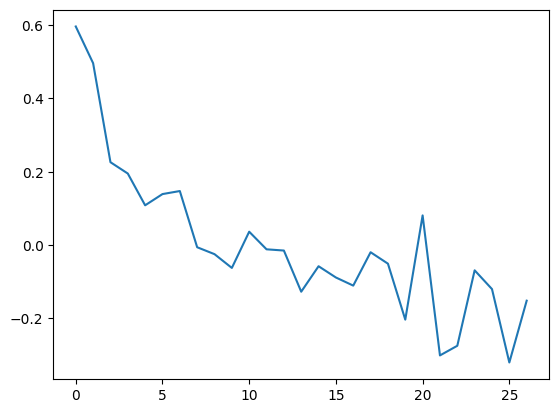

In [41]:
plt.plot(results.resid)
scipy.stats.shapiro(results.resid)

In [42]:
for trait in personality_traits:
    print(trait, scipy.stats.pearsonr(df_test[trait], df_test[measurement]))

openness PearsonRResult(statistic=-0.036778447541696194, pvalue=0.8554847979317864)
conscientiousness PearsonRResult(statistic=-0.14192126661868465, pvalue=0.48010328621366233)
neuroticism PearsonRResult(statistic=0.08005841307179638, pvalue=0.6914046619523768)
extraversion PearsonRResult(statistic=-0.13692581664929152, pvalue=0.4958465647601182)
agreeableness PearsonRResult(statistic=0.3012009116988608, pvalue=0.12682699963947855)
